In [20]:
import tensorflow as tf
import pandas as pd
import xarray as xr
import pickle
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, accuracy_score, precision_score, recall_score, f1_score, mean_absolute_error
from keras.layers import Dropout



# Deep learning model
from tensorflow.keras.layers import Input, Dense, Reshape, Concatenate, Embedding
from tensorflow.keras.models import Model, load_model, Sequential
from keras.callbacks import EarlyStopping

In [21]:
metar_data = pd.read_csv('../00_data_preparation/metar/metar_dataset_with_airport_location.csv')
#training_data = pd.read_csv('../01_data_analyzation/file_height_2021_01.csv')
#validation_data = pd.read_csv('../01_data_analyzation/file_height_2021_02.csv')
testing_data = pd.read_csv('../01_data_analyzation/file_height0_2022_02_01_09.csv')
training_data = pd.read_csv('../01_data_analyzation/file_height_2021_02_01_09.csv')

In [22]:
y_train = pd.read_csv('../01_data_analyzation/metar_file_file_height_2021_02_01_09.csv')
y_test = pd.read_csv('../01_data_analyzation/metar_file_height_2022_02_01_09.csv')

In [23]:
y_train.rename(columns={'airport_identifier': 'airport'}, inplace=True)
y_test.rename(columns={'airport_identifier': 'airport'}, inplace=True)


In [24]:
y_train['airport'].nunique()

71

In [25]:
training_data['airport'].nunique()

69

In [26]:
merged_data_train = pd.merge(y_train, training_data, on=['airport', 'time'], how='inner')
merged_data_test = pd.merge(y_test, testing_data, on=['airport', 'time'], how='inner')


In [27]:
training_data = merged_data_train.drop(columns=['contain_FZ'])
testing_data = merged_data_test.drop(columns=['contain_FZ'])

In [28]:
y_train = merged_data_train['contain_FZ']
y_test = merged_data_test['contain_FZ']

In [29]:
y_test

0        False
1        False
2        False
3        False
4        False
         ...  
10701    False
10702    False
10703    False
10704    False
10705    False
Name: contain_FZ, Length: 10706, dtype: bool

In [30]:
wind_speed = pd.read_csv('/lustre/storeB/project/AI/course/ens_wind_speed/ens_windspeed_testing.csv')

In [31]:
wind_speed

,site,sid,u10,v10,ws10,mslp,z500,tcc,sshf,slhf,cape,doy,month,ws_obs
0,SN10380,0,-2.162065,0.233785,2.174668,100012.921875,51198.382812,1.000000,1.117032e+06,1.453334e+05,2.537766,4,1,2.2
1,SN10380,0,-0.795285,2.281249,2.415900,102589.992188,54399.980469,0.999673,5.027644e+06,2.625227e+05,0.000000,11,1,1.6
2,SN10380,0,-2.948594,6.015121,6.698947,100186.062500,51931.156250,1.000000,2.798910e+06,-4.458621e+05,0.004156,15,1,11.8
3,SN10380,0,-1.717631,3.669883,4.051950,99371.578125,49946.523438,0.992263,2.040646e+06,-1.602110e+06,0.098823,18,1,7.2
4,SN10380,0,-0.697049,2.044248,2.159821,101522.320312,51519.312500,0.890855,1.649672e+06,3.623278e+05,2.661640,22,1,0.8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10199,SN9580,79,-0.248234,2.006799,2.022094,101491.000000,54169.445312,0.999826,-9.756760e+04,2.246795e+05,2.635664,329,11,1.9
10200,SN9580,79,0.419636,3.742002,3.765458,98695.046875,50504.589844,0.999113,3.018947e+06,6.981211e+05,6.853627,339,12,3.8
10201,SN9580,79,-0.404330,5.008265,5.024560,98928.179688,50739.281250,0.952109,4.895494e+06,1.010430e+05,2.775676,346,12,3.2
10202,SN9580,79,0.182370,1.006346,1.022737,99886.890625,51171.753906,0.944745,1.092381e+06,-1.038893e+05,0.854998,350,12,2.5


In [32]:
training_data

,airport,time,air_temperature_0m,fog_area_fraction,surface_air_pressure,air_pressure_at_sea_level
0,ENAL,2021-02-01 00:00:00,277.285796,0.000031,99610.329728,99647.811148
1,ENAL,2021-02-01 01:00:00,277.855323,0.000506,99605.680698,99642.889456
2,ENAL,2021-02-01 02:00:00,277.692794,0.000049,99576.191119,99614.730695
3,ENAL,2021-02-01 03:00:00,277.610191,0.000000,99572.909236,99609.618528
4,ENAL,2021-02-01 04:00:00,277.629007,0.000000,99548.594203,99585.806027
...,...,...,...,...,...,...
10615,ENZV,2021-02-08 20:00:00,262.339323,0.000000,101924.154348,102165.472709
10616,ENZV,2021-02-08 21:00:00,261.811705,0.000000,101954.185109,102195.573329
10617,ENZV,2021-02-08 22:00:00,261.540230,0.000000,101936.507816,102177.617176
10618,ENZV,2021-02-08 23:00:00,261.577304,0.000000,101902.635259,102143.746073


In [14]:
training_data['airport_id'] = pd.factorize(training_data['airport'])[0]
testing_data['airport_id'] = pd.factorize(testing_data['airport'])[0]

In [15]:
training_data

,airport,time,air_temperature_0m,fog_area_fraction,surface_air_pressure,air_pressure_at_sea_level,airport_id
0,ENAL,2021-02-01 00:00:00,277.285796,0.000031,99610.329728,99647.811148,0
1,ENAL,2021-02-01 01:00:00,277.855323,0.000506,99605.680698,99642.889456,0
2,ENAL,2021-02-01 02:00:00,277.692794,0.000049,99576.191119,99614.730695,0
3,ENAL,2021-02-01 03:00:00,277.610191,0.000000,99572.909236,99609.618528,0
4,ENAL,2021-02-01 04:00:00,277.629007,0.000000,99548.594203,99585.806027,0
...,...,...,...,...,...,...,...
10615,ENZV,2021-02-08 20:00:00,262.339323,0.000000,101924.154348,102165.472709,66
10616,ENZV,2021-02-08 21:00:00,261.811705,0.000000,101954.185109,102195.573329,66
10617,ENZV,2021-02-08 22:00:00,261.540230,0.000000,101936.507816,102177.617176,66
10618,ENZV,2021-02-08 23:00:00,261.577304,0.000000,101902.635259,102143.746073,66


In [16]:
n_airports = len(training_data['airport_id'].unique())
input_aid = Input(shape=(1,))
output_dim = 5
embedding_layer = Embedding(input_dim=n_airports, output_dim=output_dim, name="embedding_airport")(input_aid)
embedding_layer

2024-02-29 08:34:11.987340: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2256] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


<KerasTensor: shape=(None, 1, 5) dtype=float32 (created by layer 'embedding_airport')>

In [17]:
emb_cat = Reshape(target_shape=(output_dim, ))(embedding_layer)
emb_cat

<KerasTensor: shape=(None, 5) dtype=float32 (created by layer 'reshape')>

In [17]:
data_params = ['air_temperature_0m_x', 'fog_area_fraction_x', 'surface_air_pressure_x', 'air_pressure_at_sea_level_x']

In [18]:
scaler = StandardScaler()

In [19]:
training_data[data_params] = scaler.fit_transform(training_data[data_params])

KeyError: "None of [Index(['air_temperature_0m_x', 'fog_area_fraction_x', 'surface_air_pressure_x',\n       'air_pressure_at_sea_level_x'],\n      dtype='object')] are in the [columns]"

In [ ]:
training_data

In [80]:
newest_param_values = training_data.groupby(['airport', 'airport_id']).last()[data_params].reset_index()
newest_param_values_testing = testing_data.groupby(['airport', 'airport_id']).last()[data_params].reset_index()

In [64]:
newest_param_values

,airport,airport_id,air_temperature_0m,fog_area_fraction,surface_air_pressure,air_pressure_at_sea_level
0,ENAL,0,0.441781,-0.143143,0.701207,0.523112
1,ENAN,1,-0.009503,-0.141032,0.431895,0.172357
2,ENAT,2,-1.341817,0.544226,0.225397,0.142336
3,ENBJ,3,-0.816822,-0.069472,0.904514,1.045506
4,ENBL,4,-1.681099,-0.143143,-1.554519,0.493826
...,...,...,...,...,...,...
62,ENUN,62,1.044669,9.371808,0.587049,0.317214
63,ENVA,63,-1.407602,-0.111351,0.631456,0.735468
64,ENVD,64,0.416504,0.394121,0.157997,-0.290953
65,ENWV,65,0.943281,-0.143143,0.044576,-0.500428


In [81]:
merged_data = pd.merge(training_data, newest_param_values, on='airport_id', how='inner')
merged_data_test = pd.merge(testing_data, newest_param_values_testing, on='airport_id', how='inner')

In [83]:
merged_data_test

,airport_x,time,air_temperature_0m_x,fog_area_fraction_x,surface_air_pressure_x,air_pressure_at_sea_level_x,airport_id,airport_y,air_temperature_0m_y,fog_area_fraction_y,surface_air_pressure_y,air_pressure_at_sea_level_y
0,ENAL,2022-02-01 00:00:00,275.788371,0.000129,100129.003865,100233.184437,0,ENAL,277.722007,0.0,99286.600981,99388.993439
1,ENAL,2022-02-01 01:00:00,275.898712,0.001010,99997.219082,100101.814789,0,ENAL,277.722007,0.0,99286.600981,99388.993439
2,ENAL,2022-02-01 02:00:00,275.855018,0.001020,99885.292224,99989.320704,0,ENAL,277.722007,0.0,99286.600981,99388.993439
3,ENAL,2022-02-01 03:00:00,275.940897,0.008867,99691.377010,99795.423708,0,ENAL,277.722007,0.0,99286.600981,99388.993439
4,ENAL,2022-02-01 04:00:00,275.922997,0.013506,99478.530726,99582.315455,0,ENAL,277.722007,0.0,99286.600981,99388.993439
...,...,...,...,...,...,...,...,...,...,...,...,...
10701,ENZV,2022-02-08 20:00:00,277.146609,0.000000,100846.314660,101072.213712,65,ENZV,278.476186,0.0,100629.552792,100854.949628
10702,ENZV,2022-02-08 21:00:00,278.171223,0.000000,100799.182414,101024.967648,65,ENZV,278.476186,0.0,100629.552792,100854.949628
10703,ENZV,2022-02-08 22:00:00,278.002881,0.000000,100751.442888,100976.935644,65,ENZV,278.476186,0.0,100629.552792,100854.949628
10704,ENZV,2022-02-08 23:00:00,277.990098,0.000000,100678.364803,100903.795735,65,ENZV,278.476186,0.0,100629.552792,100854.949628


In [67]:
newest_data_params = ['air_temperature_0m_y', 'fog_area_fraction_y', 'surface_air_pressure_y', 'air_pressure_at_sea_level_y']

In [46]:
input_newest_param_values = Input(shape=(len(data_params),))

In [50]:
input_newest_param_values

<KerasTensor: shape=(None, 4) dtype=float32 (created by layer 'input_4')>

## Model

In [69]:
param_features_dim = Input(shape=(4,))
dense_layer_1 = Dense(units=32, activation='relu')(param_features_dim)
dropout_1 = Dropout(0.5)(dense_layer_1)
dense_layer_2 = Dense(units=16, activation='relu')(dense_layer_1)
dropout_2 = Dropout(0.5)(dense_layer_2)

In [70]:
# Concatenate embedded categorical airport feature with param features
concat = Concatenate()([emb_cat, dropout_2, input_newest_param_values])

In [71]:
output_layer = Dense(units=1, activation='sigmoid')(concat)

In [72]:
output_layer

<KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'dense_6')>

In [73]:
model = Model(inputs=[input_aid, param_features_dim, input_newest_param_values], outputs=output_layer)

In [74]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_5 (InputLayer)        [(None, 4)]                  0         []                            
                                                                                                  
 input_1 (InputLayer)        [(None, 1)]                  0         []                            
                                                                                                  
 dense_4 (Dense)             (None, 32)                   160       ['input_5[0][0]']             
                                                                                                  
 embedding_airport (Embeddi  (None, 1, 5)                 335       ['input_1[0][0]']             
 ng)                                                                                        

In [75]:
# Compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [76]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_5 (InputLayer)        [(None, 4)]                  0         []                            
                                                                                                  
 input_1 (InputLayer)        [(None, 1)]                  0         []                            
                                                                                                  
 dense_4 (Dense)             (None, 32)                   160       ['input_5[0][0]']             
                                                                                                  
 embedding_airport (Embeddi  (None, 1, 5)                 335       ['input_1[0][0]']             
 ng)                                                                                        

In [77]:
model.fit([merged_data['airport_id'], training_data[data_params], merged_data[newest_data_params]], y_train, epochs=40, batch_size=128, validation_split=0.2)

Epoch 1/40
67/67 [==============================] - 1s 4ms/step - loss: 0.4499 - accuracy: 0.8911 - val_loss: 0.2224 - val_accuracy: 0.9863
Epoch 2/40
67/67 [==============================] - 0s 2ms/step - loss: 0.1589 - accuracy: 0.9892 - val_loss: 0.1023 - val_accuracy: 0.9887
Epoch 3/40
67/67 [==============================] - 0s 2ms/step - loss: 0.0900 - accuracy: 0.9921 - val_loss: 0.0769 - val_accuracy: 0.9887
Epoch 4/40
67/67 [==============================] - 0s 2ms/step - loss: 0.0729 - accuracy: 0.9920 - val_loss: 0.0724 - val_accuracy: 0.9887
Epoch 5/40
67/67 [==============================] - 0s 2ms/step - loss: 0.0719 - accuracy: 0.9923 - val_loss: 0.0724 - val_accuracy: 0.9887
Epoch 6/40
67/67 [==============================] - 0s 2ms/step - loss: 0.0691 - accuracy: 0.9922 - val_loss: 0.0730 - val_accuracy: 0.9887
Epoch 7/40
67/67 [==============================] - 0s 2ms/step - loss: 0.0624 - accuracy: 0.9922 - val_loss: 0.0738 - val_accuracy: 0.9887
Epoch 8/40
67/67 [==

In [86]:
# Make predictions
y_pred = model.predict([merged_data_test['airport_id'], merged_data_test[data_params], merged_data_test[newest_data_params]])

335/335 [==============================] - 0s 705us/step


In [87]:
accuracy = accuracy_score(y_test, y_pred)

In [88]:
accuracy

0.9923407435083131

<AxesSubplot: >

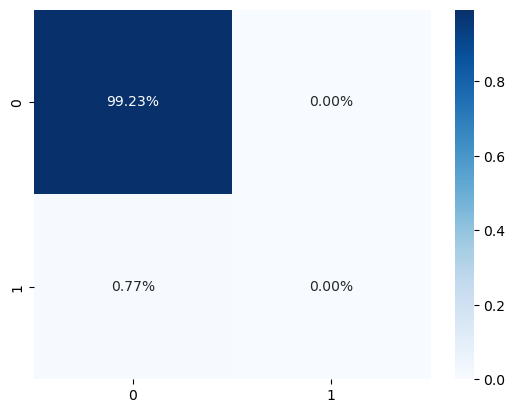

In [89]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, 
            fmt='.2%', cmap='Blues')

In [91]:
mae = mean_absolute_error(y_test, y_pred)
mae

0.0076592565